In [1]:
from dysh.spectra.spectrum import Spectrum
import numpy as np
import astropy.units as u
import matplotlib.pyplot as plt


In [2]:
y = 3.1415927+np.random.rand(1000)
x = np.arange(1000)*u.um
s = Spectrum(flux=y*u.K,spectral_axis=x,velocity_convention='doppler_radio',radial_velocity=25*u.Unit('km/s'))

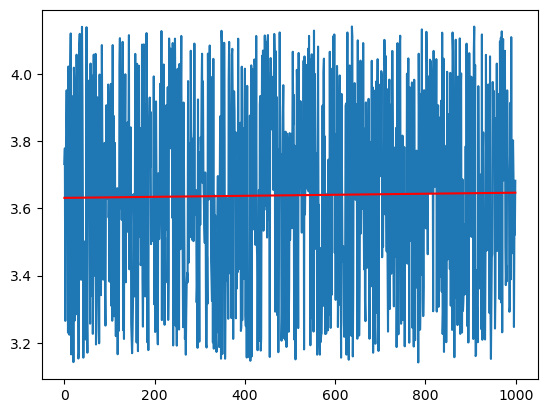

In [3]:
fig,ax=plt.subplots()
ax.plot(s.spectral_axis,s.flux)
s.baseline(1,remove=False)
ax.plot(s.spectral_axis,s._baseline_model(s.spectral_axis),color='r')

In [4]:
print(s.stats())
s.bshow()

(<Quantity 3.63897867 K>, 0.29151519553994454, <Quantity 3.1417272 K>, <Quantity 4.14104083 K>)
baseline model Model: Polynomial1D
Inputs: ('x',)
Outputs: ('y',)
Model set size: 1
Degree: 1
Parameters:
            c0                  c1         
            K                 K / um       
    ----------------- ---------------------
    3.631281704790471 1.540933817606123e-05


(<Quantity -4.19664303e-16 K>, 0.2914812548722371, <Quantity -0.50163543 K>, <Quantity 0.50805947 K>)
baseline model Model: Polynomial1D
Inputs: ('x',)
Outputs: ('y',)
Model set size: 1
Degree: 1
Parameters:
            c0                  c1         
            K                 K / um       
    ----------------- ---------------------
    3.631281704790471 1.540933817606123e-05


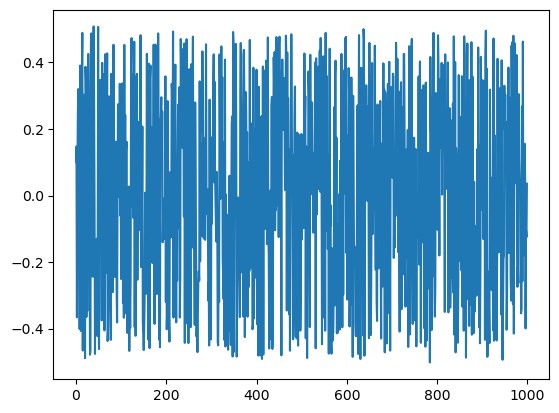

In [5]:
s = Spectrum(flux=y*u.K,spectral_axis=x,velocity_convention='doppler_radio',radial_velocity=25*u.Unit('km/s'))
s.baseline(1,remove=True)
fig,ax=plt.subplots()
ax.plot(s.spectral_axis,s.flux)
print(s.stats())
s.bshow()

In [6]:
s._undo_baseline()
print(s.stats())
s.bshow()


(<Quantity 3.63897867 K>, 0.29151519553994454, <Quantity 3.1417272 K>, <Quantity 4.14104083 K>)
baseline model None
